# $\text{Estimate TV} \iff \text{Find Classifier}$

In [44]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import config
from IPython import display
from IPython.display import clear_output
from tqdm import tqdm, trange
import time
dtype = torch.float
device = torch.device("cuda:0")

## Load Data

In [45]:
dataset = np.load(config.resource_configs['Higgs_path'])
dataset_P = dataset[dataset[:,0]==0][:, 1:] # background (5170877, 28)
dataset_Q = dataset[dataset[:,0]==1][:, 1:] # signal     (5829122, 28) 
dataset_P = torch.from_numpy(dataset_P).to(dtype=dtype, device=device)
dataset_Q = torch.from_numpy(dataset_Q).to(dtype=dtype, device=device)
# dataset_P = dataset_P[:20000]
# dataset_Q = dataset_Q[:20000]

KeyboardInterrupt: 

In [ ]:
# turn into torch loader, P=0, Q=1
dataset_P_labels = torch.zeros(dataset_P.shape[0],2).to(dtype=dtype, device=device)
dataset_P_labels[:,0] = 1
dataset_Q_labels = torch.zeros(dataset_Q.shape[0],2).to(dtype=dtype, device=device)
dataset_Q_labels[:,1] = 1
dataset_P_loader = torch.utils.data.TensorDataset(dataset_P, dataset_P_labels)
dataset_Q_loader = torch.utils.data.TensorDataset(dataset_Q, dataset_Q_labels)
dataset = torch.utils.data.ConcatDataset([dataset_P_loader, dataset_Q_loader])
# split into train and test
test_portion = 100000/len(dataset)
trainloader, testloader = torch.utils.data.random_split(dataset, [1-test_portion, test_portion])
trainloader = torch.utils.data.DataLoader(trainloader, batch_size=10240, shuffle=True)
testloader = torch.utils.data.DataLoader(testloader, batch_size=10240, shuffle=True)
print('trainloader size: %d'%len(trainloader))
print('testloader size: %d'%len(testloader))

trainloader size: 1065
testloader size: 10


## Define Net

In [ ]:
# train a classifier using torch
class Net(torch.nn.Module):
    ''' dense net'''
    def __init__(self, D_in, H, L, D_out):
        super(Net, self).__init__()
        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(D_in, H))
        self.layers.append(torch.nn.ReLU())
        for i in range(L-2):
            self.layers.append(torch.nn.Linear(H, H))
            self.layers.append(torch.nn.ReLU())
        self.layers.append(torch.nn.Linear(H, D_out))
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
net = Net(28, 100, 6, 2).to(device)

## Train

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(net.parameters())
epochs = 1000
loss_records = {'train':[], 'test':[], 'tv':[]}
fig, ax = plt.subplots()
dh = display.display(fig, display_id=True)

for epoch in range(epochs): 
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, leave=False)):
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_records['train'].append(loss.item())
        
        # print statistics
        if i % 10 == 0:    # print every 2000 mini-batches
            test_loss = 0.0
            num_test_samples = 0
            count_correct = np.zeros([2,2])
            for j, data in enumerate(testloader):
                with torch.no_grad():
                    inputs, labels = data
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item()*inputs.shape[0]
                    num_test_samples += inputs.shape[0]
                    pred = torch.argmax(outputs, dim=1)
                    label = torch.argmax(labels, dim=1)
                    count_correct[0,0] += torch.sum((label==0)*(pred==0)).item()
                    count_correct[0,1] += torch.sum((label==0)*(pred==1)).item()
                    count_correct[1,0] += torch.sum((label==1)*(pred==0)).item()
                    count_correct[1,1] += torch.sum((label==1)*(pred==1)).item()
            tv1 = (count_correct[0,0]-count_correct[1,0])/(count_correct[0,0]+count_correct[1,0]+1)
            tv0 = (count_correct[1,1]-count_correct[0,1])/(count_correct[1,1]+count_correct[0,1]+1)
            tv = (tv1+tv0)/2
            loss_records['tv'].append(tv)
            test_loss /= num_test_samples
            loss_records['test'].append(test_loss)
            ax.clear()
            ax.plot(loss_records['train'], label='train')
            test_indices = [i for i, x in enumerate(loss_records['test']) if x != 'skip']
            test_loss = [loss_records['test'][index] for index in test_indices]
            ax.plot(test_indices, test_loss, label='test')
            tv_indices = [i for i, x in enumerate(loss_records['tv']) if x != 'skip']
            tv = [loss_records['tv'][index] for index in tv_indices]
            ax.plot(tv_indices, tv, label='An $\widehat{LB}$ on TV(P,Q)')
            ax.legend()
            ax.set_xlabel('iteration')
            ax.set_ylabel('cross entropy loss')
            ax.set_title('best TV: %f'%max(tv))
            dh.update(fig)
            time.sleep(0.1)
        else:
            loss_records['test'].append('skip')
            loss_records['tv'].append('skip')
print('Finished Training')

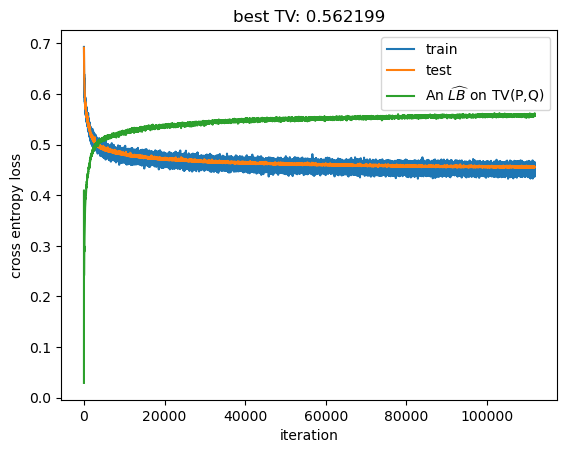

In [ ]:
# torch.save(net.state_dict(), 'classifier.pt')

## Takeaway: Use Neural Net to Estimate IPM

# Manifold Learning

## PCA

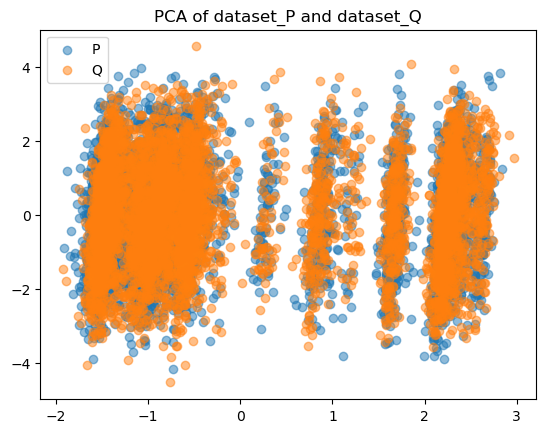

In [54]:
# Draw PCA of dataset_P and dataset_Q
from sklearn.decomposition import PCA

dataset_P_np = dataset_P.cpu().numpy()[:5000]
dataset_Q_np = dataset_Q.cpu().numpy()[:5000]
dataset_P_Q_np = np.concatenate([dataset_P_np, dataset_Q_np], axis=0)
pca = PCA(n_components=2)
pca.fit(dataset_P_Q_np)
dataset_P_Q_np_pca = pca.transform(dataset_P_Q_np)
dataset_P_np_pca = dataset_P_Q_np_pca[:dataset_P_np.shape[0],:]
dataset_Q_np_pca = dataset_P_Q_np_pca[dataset_P_np.shape[0]:,:]

# Draw PCA of dataset_P and dataset_Q
fig, ax = plt.subplots()
ax.scatter(dataset_P_np_pca[:,0], dataset_P_np_pca[:,1], label='P', alpha=0.5)
ax.scatter(dataset_Q_np_pca[:,0], dataset_Q_np_pca[:,1], label='Q', alpha=0.5)
ax.legend()
ax.set_title('PCA of dataset_P and dataset_Q')
plt.show()


## T-SNE

/math/home/eruisun/software/anaconda/envs/LFI/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/math/home/eruisun/software/anaconda/envs/LFI/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


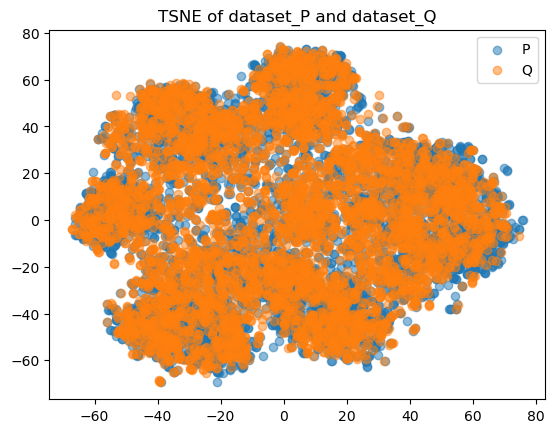

In [55]:
import sklearn
# sklearn.manifold.TSNE to data
from sklearn.manifold import TSNE
dataset_P_Q_np_tsne = TSNE(n_components=2).fit_transform(dataset_P_Q_np)
dataset_P_np_tsne = dataset_P_Q_np_tsne[:dataset_P_np.shape[0],:]
dataset_Q_np_tsne = dataset_P_Q_np_tsne[dataset_P_np.shape[0]:,:]

# Draw TSNE of dataset_P and dataset_Q
fig, ax = plt.subplots()
ax.scatter(dataset_P_np_tsne[:,0], dataset_P_np_tsne[:,1], label='P', alpha=0.5)
ax.scatter(dataset_Q_np_tsne[:,0], dataset_Q_np_tsne[:,1], label='Q', alpha=0.5)
ax.legend()
ax.set_title('TSNE of dataset_P and dataset_Q')
plt.show()

## Isomap

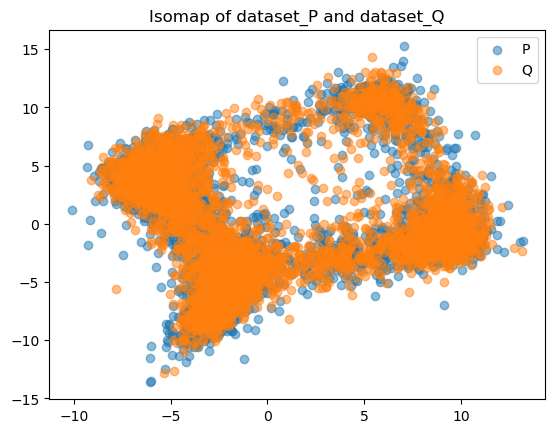

In [56]:
from sklearn.manifold import Isomap

dataset_P_Q_np_isomap = Isomap(n_components=2).fit_transform(dataset_P_Q_np)
dataset_P_np_isomap = dataset_P_Q_np_isomap[:dataset_P_np.shape[0],:]
dataset_Q_np_isomap = dataset_P_Q_np_isomap[dataset_P_np.shape[0]:,:]

# Draw Isomap of dataset_P and dataset_Q
fig, ax = plt.subplots()
ax.scatter(dataset_P_np_isomap[:,0], dataset_P_np_isomap[:,1], label='P', alpha=0.5)
ax.scatter(dataset_Q_np_isomap[:,0], dataset_Q_np_isomap[:,1], label='Q', alpha=0.5)
ax.legend()

ax.set_title('Isomap of dataset_P and dataset_Q')
plt.show()


# $\chi^2(Q||P)$

$${\displaystyle \chi ^{2}(P;Q)=\sup _{g}{\frac {(E_{P}[g(X)]-E_{Q}[g(X)])^{2}}{Var_{Q}[g(X)]}}}$$
$${\displaystyle \chi ^{2}(P;Q)=\sup _{g}E_{P}[g(X)]-E_{Q}[g(X)^{2}/4+g(X)]}$$
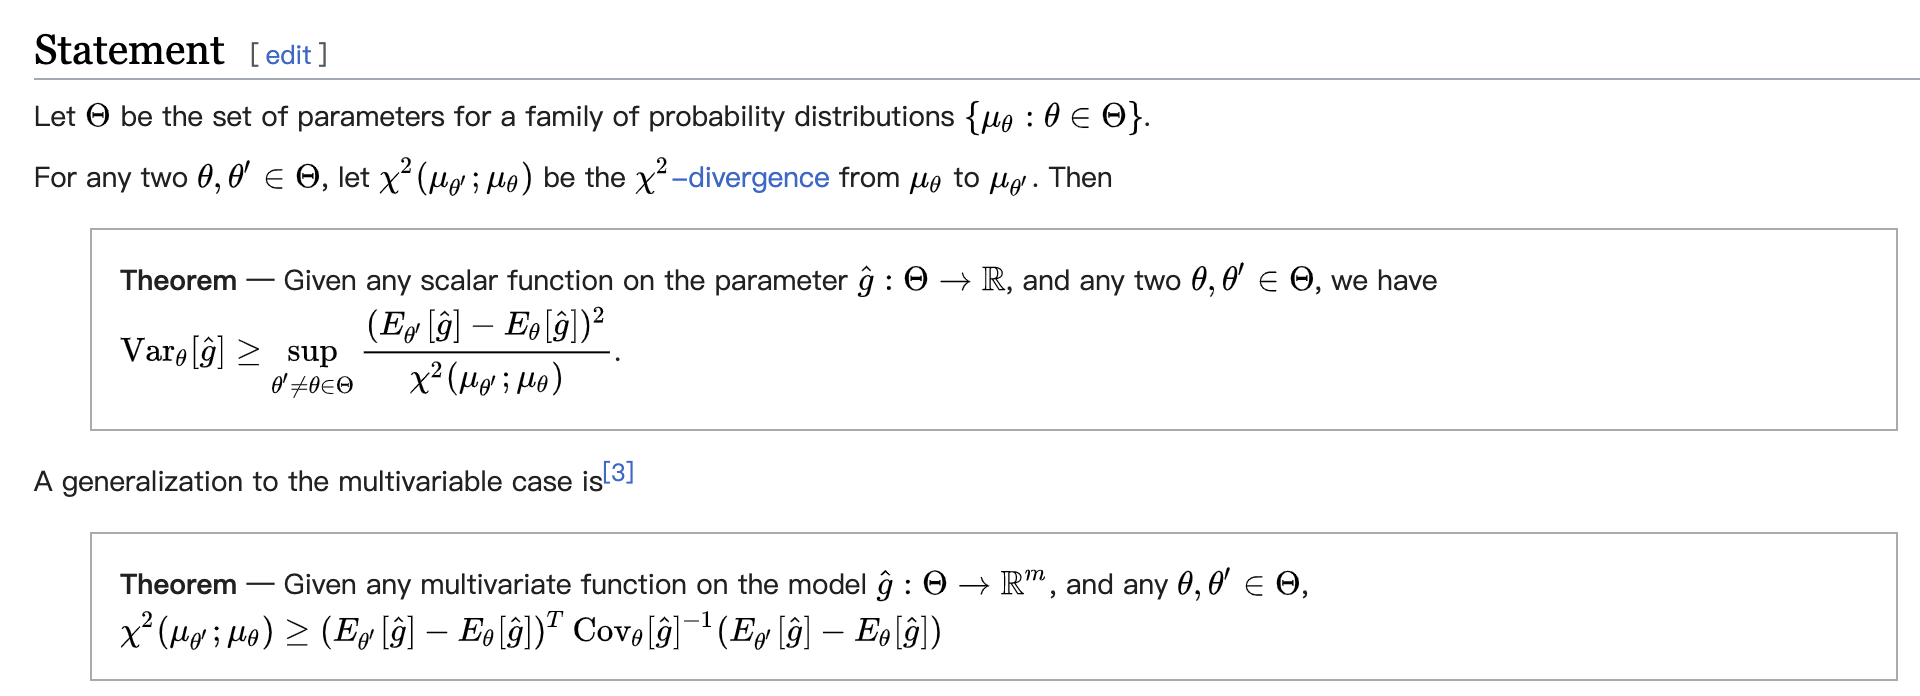
$$\text{This is similar to Cramer-Rao!}$$
$$ \chi^2(Q,P) = \int \left( \frac{\mathrm{d}Q}{\mathrm{d}P}−1\right)^2 \mathrm{d}P$$

## 1: Use sup mean/var

In [77]:
# !python train_classifier.py 1000000 mean/var
clear_output()
!python test_classifier.py 1000000 mean/var


------------------- n_tr = 1000000 -------------------
thres = 0.2688
plotting histogram to /math/home/eruisun/github/LFI/other/plots/n_tr=1000000
thres = 0.2648
plotting histogram to /math/home/eruisun/github/LFI/other/plots/n_tr=1000000
thres = 0.2640
plotting histogram to /math/home/eruisun/github/LFI/other/plots/n_tr=1000000
thres = 0.2622
plotting histogram to /math/home/eruisun/github/LFI/other/plots/n_tr=1000000
thres = 0.2651
plotting histogram to /math/home/eruisun/github/LFI/other/plots/n_tr=1000000
p_soft_mean_T =  2.462930202484131
p_soft_std_T =  0.4269387120048405
p_hard_mean_T =  1.6577797285753757
p_hard_std_T =  0.10038884431684228


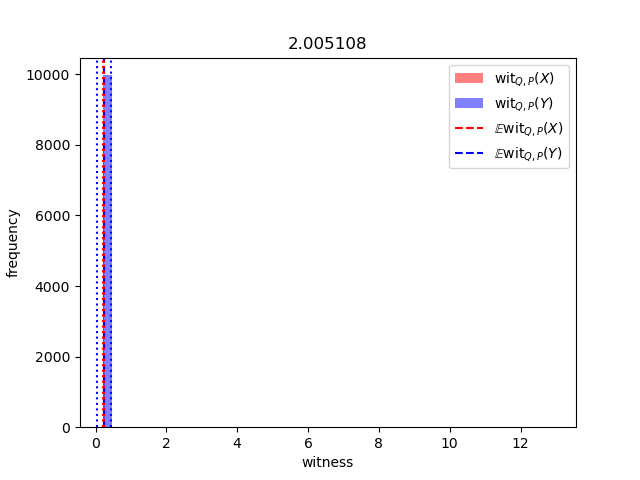

In [78]:
# load figure.png
from IPython.display import Image
Image('./plots/n_tr=1000000/hist.png')

## 2: Use sup wiki loss

In [75]:
# !python train_classifier.py 1000001 chi_square_on_wiki
clear_output()
!python test_classifier.py 1000001 chi_square_on_wiki

------------------- n_tr = 1000001 -------------------
thres = 0.6075
plotting histogram to /math/home/eruisun/github/LFI/other/plots/n_tr=1000001
thres = 0.4001
plotting histogram to /math/home/eruisun/github/LFI/other/plots/n_tr=1000001
thres = 0.4821
plotting histogram to /math/home/eruisun/github/LFI/other/plots/n_tr=1000001
thres = 0.6847
plotting histogram to /math/home/eruisun/github/LFI/other/plots/n_tr=1000001
thres = 0.4506
plotting histogram to /math/home/eruisun/github/LFI/other/plots/n_tr=1000001
p_soft_mean_T =  -0.44909125566482544
p_soft_std_T =  0.020284736784894907
p_hard_mean_T =  1.2580482947058755
p_hard_std_T =  0.0


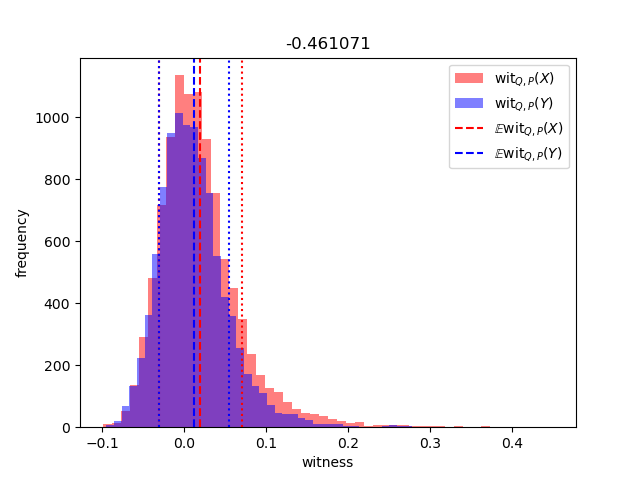

In [76]:
# load figure.png
from IPython.display import Image
Image('./plots/n_tr=1000001/hist.png')

## 3:heuristic (Le-Cam loss)

In [74]:
# !python train_classifier.py 1000002 heuristic
clear_output()
!python test_classifier.py 1000002 heuristic

------------------- n_tr = 1000002 -------------------
thres = 0.0560
plotting histogram to /math/home/eruisun/github/LFI/other/plots/n_tr=1000002
thres = 0.0572
plotting histogram to /math/home/eruisun/github/LFI/other/plots/n_tr=1000002
thres = 0.0538
plotting histogram to /math/home/eruisun/github/LFI/other/plots/n_tr=1000002
thres = 0.0532
plotting histogram to /math/home/eruisun/github/LFI/other/plots/n_tr=1000002
thres = 0.0555
plotting histogram to /math/home/eruisun/github/LFI/other/plots/n_tr=1000002
p_soft_mean_T =  4.090171527862549
p_soft_std_T =  0.05892314025598707
p_hard_mean_T =  4.353553822204946
p_hard_std_T =  0.15384350896176896


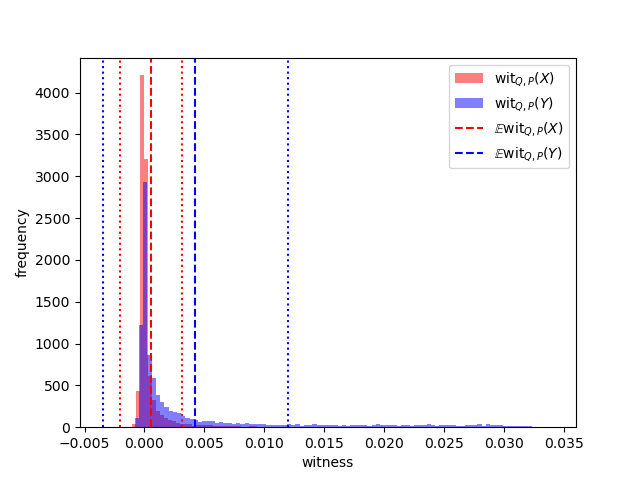

In [72]:
# load figure.png
from IPython.display import Image
Image('./plots/n_tr=1000002/hist.png')

## 4: Kernel

In [79]:
# !python train.py 
clear_output()
!python test.py 1000000

------------------- n_tr = 1000000 -------------------
plotting histogram to /math/home/eruisun/github/LFI/other/plots/n_tr=1000000
thres = 0.1487
plotting histogram to /math/home/eruisun/github/LFI/other/plots/n_tr=1000000
thres = 0.1375
plotting histogram to /math/home/eruisun/github/LFI/other/plots/n_tr=1000000
thres = 0.1520
plotting histogram to /math/home/eruisun/github/LFI/other/plots/n_tr=1000000
thres = 0.1465
plotting histogram to /math/home/eruisun/github/LFI/other/plots/n_tr=1000000
thres = 0.1311
p_soft_mean =  4.383191776275635
p_soft_std =  0.03530952873054885
p_hard_mean =  4.70672752282011
p_hard_std =  0.10117550201080051


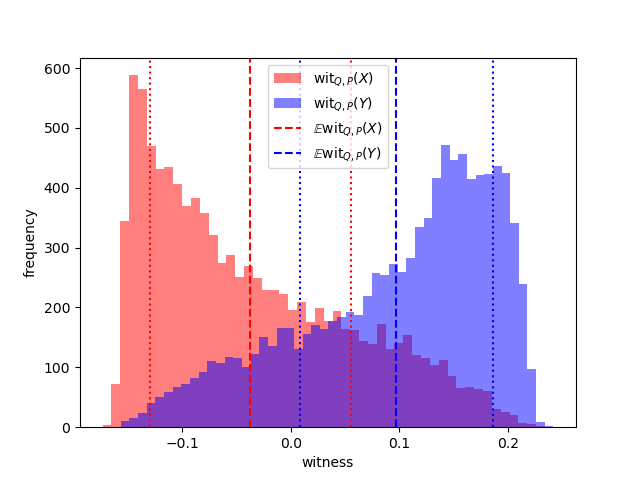

In [82]:
# load figure.png
from IPython.display import Image
Image('./plots/n_tr=1000000/hist.png')

## 算上界

$$\max_{T:\mathcal{X}\to\mathbb{R}}\quad Z:=\frac{\mathbb{E}T(Y)-\mathbb{E}T(X)}{\mathrm{Var}(T(X))}.$$
$$Z_*^2\leq \chi^2(Q^n||P^n) = [1+\chi^2(Q||P)]^n-1.$$
$$但太松了，不能用。所以只能对 score-function-alike 的方法 claim 是 \sqrt{m}\chi(Q||P)$$
————————————————————————————————————————————————————————————————————————————————

$$直接考虑 T:\mathcal{X^m}\to\mathbb{R}$$
$$注意 \mathbb{E}[pval|H_0]=\frac12，是[0,1]上均匀分布!$$
$$\min_{T:\mathcal{X^m}\to\mathbb{R}}\quad \mathbb{E}[pval|H_1]:=\mathbb{E}_{Y^m}[\mathbb{P}_{X^m}(T(X^m)>T(Y^m))]=\mathbb{P}(T(X^m)>T(Y^m)).$$
$$在最后一个block看离散形式$$
$$调整法，每次交换\sigma(l)和\sigma(l+1)，得到T和\frac{q}{p}顺序一样，即T=\frac{q}{p}最佳，和\chi^2的分析一样！$$
$$在T=\frac{q}{p}（可以再复合任意函数！）下可以画ROC，ROC的面积是\mathbb{E}[pval]$$
$$同时是\int p(x^m)q(y^m)\mathbb{I}\left(\frac{q(x^m)}{p(x^m)}>\frac{q(y^m)}{p(y^m)}\right)\mathrm{d}x^m\mathrm{d}y^m.$$ 
————————————————————————————————————————————————————————————————————————————————


$$另外一种$$
$$\max_{T:\mathcal{X^m}\to\mathbb{R}}\quad pval(\mathbb{E}T(Q)):=\mathbb{P}_{X^m}[T(X^m)>\mathbb{E}_{Y^m}[T(Y^m)]].$$
$$
\begin{align}
    \left(
    \begin{aligned}
        \min_{T:\mathcal{X^m}\to\mathbb{R}, t\in\mathbb{R}}&\quad \mathbb{P}_{X^m}[T(X^m)>t] \\
        \mathrm{s.t.}&\quad \mathbb{E}_{Y^m}[T(Y^m)]=t
    \end{aligned}
    \right)
\end{align}
$$
$$
\begin{align}
    \left(
    \begin{aligned}
        \min_{T:\mathcal{X^m}\to\mathbb{R}, t\in\mathbb{R}, S\subset\mathcal{X}^m} &\quad \mathbb{P}_{X^m}[S] \\
        \mathrm{s.t.}&\quad \mathbb{E}_{Y^m}[T(Y^m)]=t,\quad S=\{T>t\}
    \end{aligned}
    \right)
\end{align}
$$
$$
\begin{align}
    \left(
    \begin{aligned}
        \min &\quad \sum_{i=1}^k p_i \cdot \mathbb{I}(T_i>t)\\
        \mathrm{s.t.}&\quad \sum_{i=1}^k q_i\cdot T_i=t
    \end{aligned}
    \right)
\end{align}
$$
$$所以最佳的T应该只在\{t^-,+\infty\}取值， 解是 T 在除了一个单点外取常数$$
$$\min\{p_i|q_i>0\}$$
————————————————————————————————————————————————————————————————————————————————


$$另外一种: 先做\Phi变换，再平均$$
$$\min_{T:\mathcal{X^m}\to\mathbb{R}}\quad \mathbb{E}_{Y^m}\left[ Q^{-1}\left\{ \mathbb{P}_{X^m}[T(X^m)>T(Y^m)] \right\} \right].$$
$$\min \quad \sum_{j=1}^k q_j \cdot Q^{-1}\left( \sum_{i=1}^k p_i \mathbb{I}(T_i>T_j) \right).$$
$$\min_\sigma \quad \sum_{j=1}^k q_{\sigma(j)} \cdot Q^{-1}\left( p_{\sigma(1)}+\cdots+p_{\sigma(j)} \right).$$
$$如果没有Q，调整法，每次交换\sigma(l)和\sigma(l+1)，得到T和\frac{q}{p}顺序一样，即T=\frac{q}{p}最佳，和\chi^2的分析一样！$$
$$Q存不存在并不影响$$
$$obj^*=$$

————————————————————————————————————————————————————————————————————————————————


$$TV和\chi^2有没有不等式？$$

# Hellinger
$${\displaystyle H^{2}(P,Q)=\int _{\mathcal {X}}\left({\sqrt {P(dx)}}-{\sqrt {Q(dx)}}\right)^{2}.}$$
$${\displaystyle \frac12 H^{2}(P,Q)\leq TV (P,Q)\leq H(P,Q)\sqrt{1-\frac14H^{2}(P,Q)}\leq 1.}$$
$$ H^2(P^n,Q^n)=2-2(1-\frac12 H^2(P,Q))^n.$$
$$ 1-[1-\frac12 H^2(P,Q)]^n \leq TV(P^n,Q^n)\leq \sqrt{1-[1-\frac12 H^2(P,Q)]^{2n}}. $$
$$1-\frac12 e^{-n\,2\ln\left(\frac{1}{1-\frac12 H^2(P,Q)}\right)} \geq TV(P^n,Q^n)\geq 1-e^{-n\,\frac12 H^2(P,Q)}.$$